<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/CNN_523embed_12K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 523

1. Four layers of CNNS and MaxPooling
2. Drop out at 0.2
3. Variable filters and dense neurons














In [1]:
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'
NC_FILENAME='noncod_12000.fasta'  # CHANGE THIS TO 1000, 2000, 4000, etc.
PC_FILENAME='coding_12000.fasta'
NC_VAL_FILE='noncod_validation.fasta'  # 'noncod_validation.fasta'  # CHANGE THIS TO THE UNIFORM VALIDATION FILE
PC_VAL_FILE='coding_validation.fasta'  # 'coding_validation.fasta'

MODEL_FILE='JUNK3'   # CHANGE THIS IF YOU WANT TO SAVE THE MODEL!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
NC_VAL_FILE = DATAPATH+NC_VAL_FILE
PC_VAL_FILE = DATAPATH+PC_VAL_FILE
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=20  # DECIDE ON SOME AMOUNT AND STICK WITH IT
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=32
KERNEL=3
NEURONS=24
DROP=0.2
MINLEN=200
MAXLEN=1000    # THIS HAS TO MATCH THE SIMULATION DATA
DENSE_LEN = 1000
ACT="tanh"

Mounted at /content/drive/


In [2]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    #SHAPE=(MAXLEN,5)  
    SHAPE=(MAXLEN,4)  
    # 4 input letters, 4 output dimensions, 1000 letters/RNA
    elayer  = keras.layers.Embedding(4,4,input_length=1000) 

    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer8 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer9 = keras.layers.MaxPooling1D(2)
    clayer10 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer11 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer12 = keras.layers.MaxPooling1D(2)

    clayer13 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[DENSE_LEN])
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    cnn.add(elayer)
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    cnn.add(clayer4)
    cnn.add(clayer5)
    cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(clayer8)
    cnn.add(clayer9)
    cnn.add(clayer10)
    cnn.add(clayer11)
    cnn.add(clayer12)
    cnn.add(clayer13)
    cnn.add(dlayer1)
    cnn.add(dlayer2)
    cnn.add(dlayer3)
    cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [5]:
def do_cross_validation(X,y,given_model,X_VALID,Y_VALID):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, 
                epochs=EPOCHS, verbose=1, callbacks=mycallbacks,
                validation_data=(X_valid,y_valid))
        # THE VALIDATION ABOVE IS JUST FOR SHOW
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        # THE VALIDATION BELOW IS FOR KEEPS
        scores = best_model.evaluate(X_VALID, Y_VALID, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [6]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 4)           16        
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 32)          416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 32)           3104      
_____________________________________________________________

In [7]:
def load_data_from_files(nc_filename,pc_filename):
  FREEMEM=True   # use False for debugging, True for production
  print("Load data from files.")
  nc_seq=tools.load_fasta(nc_filename,0)
  pc_seq=tools.load_fasta(pc_filename,1)
  train_set=pd.concat((nc_seq,pc_seq),axis=0)
  print("Ready: train_set")
  subset=tools.make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
  if FREEMEM:
      nc_seq=None
      pc_seq=None
      train_set=None
  (X1,y_train)=tools.separate_X_and_y(subset)
  # X1 is pandas df of ("list" of one sequence)
  X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
  X3=[elem[0] for elem in X2]  # numpy ndarray of ACGT-str
  # X3? It might be faster to use int-array than char-array. Come back to this.
  X4=X3  # no-op
  print("X4",type(X4))
  #print(X4[0])
  if FREEMEM:
      X1=None
      X2=None
      X3=None
  X5=[]
  dna_to_int = {'A':0,'C':1,'G':2,'T':3}
  for x in X4:
      a=[]
      for c in x:
          i = dna_to_int[c]
          a.append(i)
      X5.append(a)
  X5=np.asarray(X5)
  print("X5",type(X5))
  print(X5.shape)
  if FREEMEM:
      X4=None
  X_train=X5
  if FREEMEM:
      X5=None
  print("X_train",type(X_train))
  y_train=y_train.to_numpy()
  print(X_train.shape)
  print(X_train[0].shape)
  print(X_train[0])
  return X_train,y_train


In [8]:
print("Loading training data...")
X_train,y_train = load_data_from_files(NC_FILENAME,PC_FILENAME)

Loading training data...
Load data from files.
Ready: train_set
X4 <class 'list'>
X5 <class 'numpy.ndarray'>
(24000, 1000)
X_train <class 'numpy.ndarray'>
(24000, 1000)
(1000,)
[0 1 1 1 1 3 2 1 0 1 3 3 3 2 1 1 3 2 3 0 0 3 3 3 0 2 2 3 0 0 1 1 3 3 1 0 3
 1 3 2 1 2 1 3 2 1 0 3 2 3 0 2 1 1 0 1 1 1 3 2 1 0 1 2 0 1 3 3 0 2 1 2 0 3
 0 2 1 1 1 2 0 3 1 3 3 2 2 1 0 2 2 2 1 0 3 1 2 0 3 0 2 1 3 3 0 2 2 1 2 1 1
 2 3 0 1 3 1 3 0 3 3 0 3 0 0 0 3 1 3 0 3 3 2 0 0 0 1 1 2 2 2 0 3 0 0 0 3 1
 2 1 1 2 1 1 0 1 1 1 2 3 1 2 1 3 3 3 3 1 0 1 2 0 3 3 3 0 2 3 3 1 0 3 3 0 3
 1 2 2 3 1 1 1 0 2 3 3 2 1 1 2 2 1 2 1 1 3 0 2 1 1 1 0 2 1 3 1 3 2 2 3 3 1
 2 2 2 0 2 2 3 3 1 2 0 0 3 3 0 3 0 3 1 0 1 3 1 2 3 1 1 1 1 0 0 0 0 3 0 0 1
 1 2 1 1 0 3 2 1 1 2 3 3 3 3 2 1 3 3 0 2 0 1 3 2 3 0 3 2 1 3 2 1 1 3 1 0 2
 0 3 3 3 1 1 1 0 3 2 0 0 0 2 3 2 1 0 3 0 1 1 0 2 2 0 1 3 2 0 0 0 2 2 3 1 3
 1 0 3 1 1 2 3 2 0 2 1 0 1 0 2 1 2 3 0 0 3 0 1 2 0 2 2 3 3 1 0 0 0 0 3 1 1
 2 1 1 3 3 1 3 3 3 0 0 1 0 0 3 3 3 2 0 2 1 3 2 1 3 0 3 2 1 0 3 0 2 2 0 0 

In [9]:
print("Loading validation data...")
X_VALID,Y_VALID = load_data_from_files(NC_VAL_FILE,PC_VAL_FILE)

Loading validation data...
Load data from files.
Ready: train_set
X4 <class 'list'>
X5 <class 'numpy.ndarray'>
(100000, 1000)
X_train <class 'numpy.ndarray'>
(100000, 1000)
(1000,)
[1 3 1 3 3 2 2 3 1 0 0 3 0 0 2 0 1 1 1 1 0 3 1 3 3 2 3 2 2 2 0 0 3 2 3 2 2
 1 0 3 0 3 1 0 3 0 0 1 2 3 3 0 1 2 2 0 2 1 3 3 2 2 1 2 3 2 1 1 3 2 3 1 1 1
 2 2 1 1 2 0 2 0 2 0 1 2 0 3 3 2 2 3 1 1 1 1 3 3 0 0 1 1 2 0 3 3 2 3 3 0 3
 3 1 0 1 0 2 2 3 1 1 1 1 2 1 0 1 0 0 3 1 3 3 1 1 3 3 3 0 0 1 1 0 2 3 3 1 1
 3 0 1 1 0 2 0 2 2 2 2 1 0 0 2 0 1 1 0 0 1 2 2 0 2 3 3 2 0 1 1 1 3 1 3 1 1
 0 0 0 3 3 1 0 0 0 0 1 0 0 1 1 1 3 2 2 1 1 2 3 1 2 2 1 1 2 0 0 0 2 0 3 0 1
 3 1 1 0 0 2 1 0 1 2 0 3 0 3 3 2 2 3 3 3 1 3 0 2 0 2 0 3 1 2 1 0 0 2 3 2 1
 2 0 1 1 0 3 0 2 3 3 3 1 2 2 1 0 1 3 1 0 1 3 0 3 2 0 0 2 0 1 1 1 1 3 1 1 1
 2 0 0 2 2 3 2 1 0 3 2 1 2 3 3 0 2 1 3 0 2 2 3 3 2 1 0 3 1 3 1 2 0 3 2 2 2
 3 2 1 1 3 1 0 3 0 2 3 0 1 3 1 3 1 1 3 1 0 1 2 2 3 3 2 2 0 0 0 0 0 1 0 0 2
 0 1 1 3 2 1 2 1 3 3 2 2 0 1 2 1 2 2 1 1 3 2 1 0 2 2 2 1 3 3 2 1 0 3 

Cross validation
COMPILE...
...COMPILED
FIT
Epoch 1/20
675/675 [==============================] - 10s 8ms/step - loss: 0.6874 - accuracy: 0.5398 - val_loss: 0.6488 - val_accuracy: 0.6283
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.1.best/assets
Epoch 2/20
675/675 [==============================] - 5s 7ms/step - loss: 0.6449 - accuracy: 0.6345 - val_loss: 0.5666 - val_accuracy: 0.7054
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.1.best/assets
Epoch 3/20
675/675 [==============================] - 5s 7ms/step - loss: 0.5406 - accuracy: 0.7288 - val_loss: 0.3165 - val_accuracy: 0.8696
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.1.best/assets
Epoch 4/20
675/675 [==============================] - 5s 7ms/step - loss: 0.2590 - accuracy: 0.8977 - val_loss: 0.1144 - val_accuracy: 0.9567
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.1.best/assets
Epoch 5/20
675/675 [===================

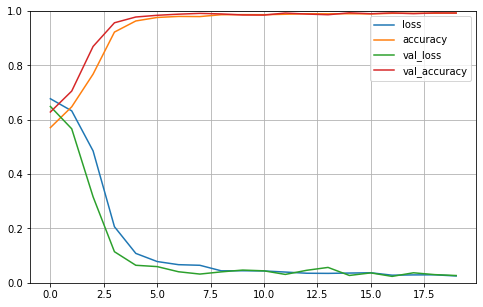

accuracy: 99.14%
COMPILE...
...COMPILED
FIT
Epoch 1/20
675/675 [==============================] - 6s 7ms/step - loss: 0.6967 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5129
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.2.best/assets
Epoch 2/20
675/675 [==============================] - 5s 7ms/step - loss: 0.6948 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4871
Epoch 3/20
675/675 [==============================] - 5s 7ms/step - loss: 0.6946 - accuracy: 0.4935 - val_loss: 0.6934 - val_accuracy: 0.4871
Epoch 4/20
675/675 [==============================] - 5s 7ms/step - loss: 0.6937 - accuracy: 0.5038 - val_loss: 0.6928 - val_accuracy: 0.5129
Epoch 5/20
675/675 [==============================] - 5s 7ms/step - loss: 0.6942 - accuracy: 0.5045 - val_loss: 0.6935 - val_accuracy: 0.4871
Epoch 6/20
675/675 [==============================] - 5s 7ms/step - loss: 0.6940 - accuracy: 0.4992 - val_loss: 0.6935 - val_accuracy: 0.4871
Epoch 7/20
675/67

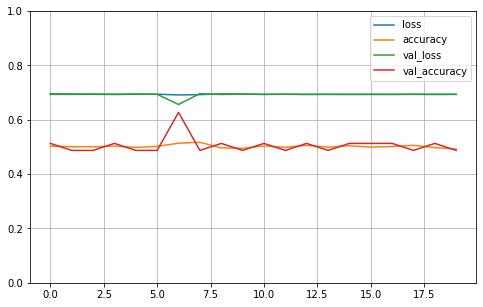

accuracy: 63.82%
COMPILE...
...COMPILED
FIT
Epoch 1/20
675/675 [==============================] - 6s 7ms/step - loss: 0.6954 - accuracy: 0.5096 - val_loss: 0.6434 - val_accuracy: 0.6137
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.3.best/assets
Epoch 2/20
675/675 [==============================] - 5s 7ms/step - loss: 0.5160 - accuracy: 0.7430 - val_loss: 0.1888 - val_accuracy: 0.9217
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.3.best/assets
Epoch 3/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1765 - accuracy: 0.9379 - val_loss: 0.0944 - val_accuracy: 0.9729
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.3.best/assets
Epoch 4/20
675/675 [==============================] - 5s 7ms/step - loss: 0.0869 - accuracy: 0.9724 - val_loss: 0.0574 - val_accuracy: 0.9842
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.3.best/assets
Epoch 5/20
675/675 [====================

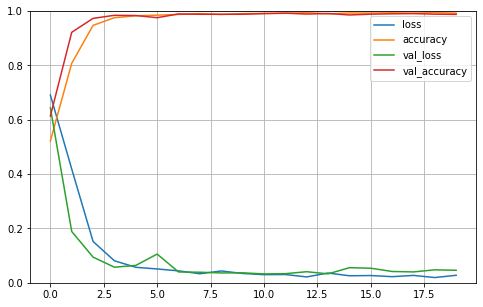

accuracy: 99.15%
COMPILE...
...COMPILED
FIT
Epoch 1/20
675/675 [==============================] - 6s 7ms/step - loss: 0.6883 - accuracy: 0.5452 - val_loss: 0.6287 - val_accuracy: 0.6454
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.4.best/assets
Epoch 2/20
675/675 [==============================] - 5s 7ms/step - loss: 0.5865 - accuracy: 0.6943 - val_loss: 0.4576 - val_accuracy: 0.7812
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.4.best/assets
Epoch 3/20
675/675 [==============================] - 5s 7ms/step - loss: 0.3714 - accuracy: 0.8417 - val_loss: 0.1306 - val_accuracy: 0.9517
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.4.best/assets
Epoch 4/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1645 - accuracy: 0.9432 - val_loss: 0.0826 - val_accuracy: 0.9775
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.4.best/assets
Epoch 5/20
675/675 [====================

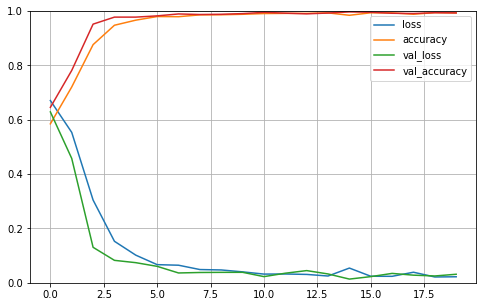

accuracy: 99.14%
COMPILE...
...COMPILED
FIT
Epoch 1/20
675/675 [==============================] - 6s 7ms/step - loss: 0.6948 - accuracy: 0.5092 - val_loss: 0.6554 - val_accuracy: 0.6133
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.5.best/assets
Epoch 2/20
675/675 [==============================] - 5s 7ms/step - loss: 0.6109 - accuracy: 0.6668 - val_loss: 0.4830 - val_accuracy: 0.7654
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.5.best/assets
Epoch 3/20
675/675 [==============================] - 5s 7ms/step - loss: 0.4070 - accuracy: 0.8170 - val_loss: 0.1939 - val_accuracy: 0.9254
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.5.best/assets
Epoch 4/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1755 - accuracy: 0.9362 - val_loss: 0.0981 - val_accuracy: 0.9675
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK3.cv.5.best/assets
Epoch 5/20
675/675 [====================

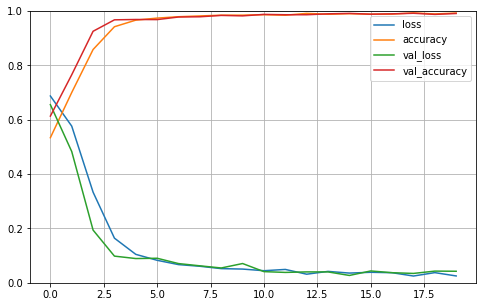

accuracy: 99.04%

5-way Cross Validation mean 92.06% (+/- 14.12%)
Done


In [10]:
print ("Cross validation")
do_cross_validation(X_train,y_train,model,X_VALID,Y_VALID)  
print ("Done")